Epoch 1/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.1350 - val_loss: 0.0245
Epoch 2/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 0.0217 - val_loss: 0.0113
Epoch 3/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.0110 - val_loss: 0.0078
Epoch 4/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - loss: 0.0074 - val_loss: 0.0060
Epoch 5/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 0.0061 - val_loss: 0.0048
Epoch 6/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.0049 - val_loss: 0.0040
Epoch 7/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 8/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - loss: 0.0037 - val_loss: 0.0030
Epoch 9/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 10/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 11/500
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 12/500
701/70

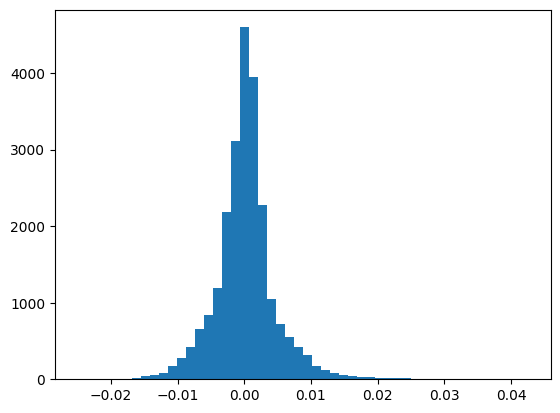

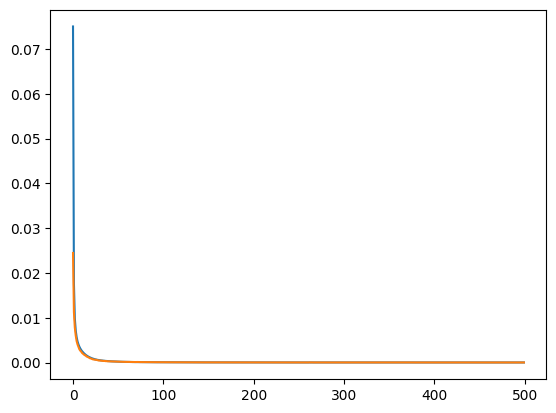

                    count       mean        std           min        25%  \
days_to_maturity  23580.0  48.222222  32.907225  7.000000e+00  28.000000   
fixing_frequency  23580.0  31.111111  29.719477  7.000000e+00   7.000000   
past_fixings      23580.0   0.000000   0.000000  0.000000e+00   0.000000   
risk_free_rate    23580.0   0.001601   0.000254  9.160000e-04   0.001527   
dividend_rate     23580.0   0.020649   0.000619  1.940600e-02   0.020155   
kappa             23580.0   6.499276  10.013034  7.270436e-09   0.539286   
theta             23580.0   0.136201   0.184574  1.896277e-09   0.045679   
rho               23580.0  -0.793695   0.138855 -1.000000e+00  -0.846642   
eta               23580.0   1.894142   1.713081  2.442695e-01   0.601996   
v0                23580.0   0.088573   0.109829  1.881829e-04   0.018266   
relative_spot     23580.0   1.160312   0.476547  6.666667e-01   0.800000   

                        50%        75%        max  
days_to_maturity  28.000000  84.000

In [1]:
from testing_keras import tictoc, dataset, development_dates, \
    test_dates, train_data, test_data, train_X, test_X, train_y, \
        test_y, normalizer, build_and_compile_model, mlp, pricename

In [2]:
import numpy as np

In [3]:
insample = mlp.predict(train_X).flatten()
insample_error = insample-train_y
insample_MAE = np.mean(np.abs(insample_error))
insample_RMSE = np.sqrt(np.mean(insample_error**2))
print(f"in-sample:\n   MAE: {insample_MAE}\n   RMSE: {insample_RMSE}")

737/737 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
in-sample:
   MAE: 0.0031480367553845673
   RMSE: 0.004597803177423071


In [4]:
outsample = mlp.predict(test_X).flatten()
outsample_error = outsample-test_y
outsample_MAE = np.mean(np.abs(outsample_error))
outsample_RMSE = np.sqrt(np.mean(outsample_error**2))
print(f"out-of-sample:\n   MAE: {outsample_MAE}\n   RMSE: {outsample_RMSE}")

9855/9855 ━━━━━━━━━━━━━━━━━━━━ 5s 546us/step
out-of-sample:
   MAE: 0.05818279107306421
   RMSE: 0.1257368867439903
